In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import seaborn as sns
from scipy import stats
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
sns.set()



# yvr, yvrCases
# %store -r

In [2]:
yvr = pd.read_csv('yvr4analyze_both.csv')
yvrCases = pd.read_csv('Covid-Data/yvr-modified.csv')

# For some reason, the "Date" column wasn't being interpeted by the parsing arguments through input
# Or in pd.to_csv(). So we need to reformat it into datetime type when we reimport it
# It wasn't an issue when it was indirectly referenced via %store so maybe converting it csv 
# wiped out something?

yvr["Date"] = pd.to_datetime(yvr["Date"])
yvrCases["Date"] = pd.to_datetime(yvrCases["Date"])

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


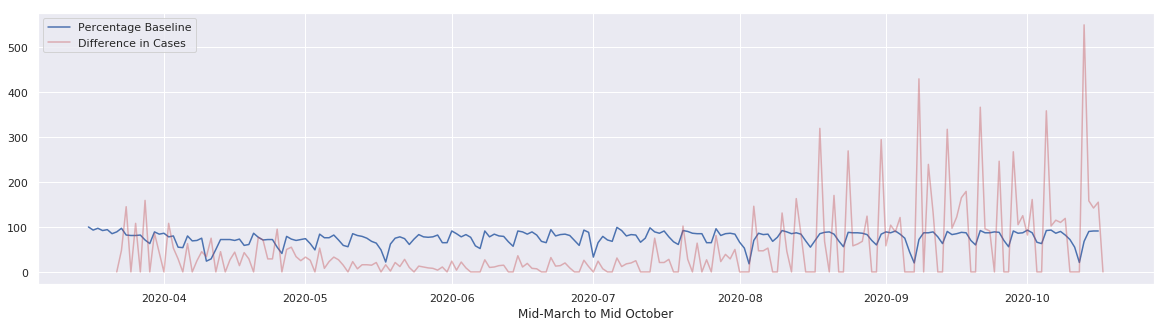

In [3]:
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yvrCases["Date"], yvrCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

Date                 208
Difference           208
Confirmed            208
Diff_smooth          208
PercentOfBaseline    208
Baseline_smooth      208
dtype: int64


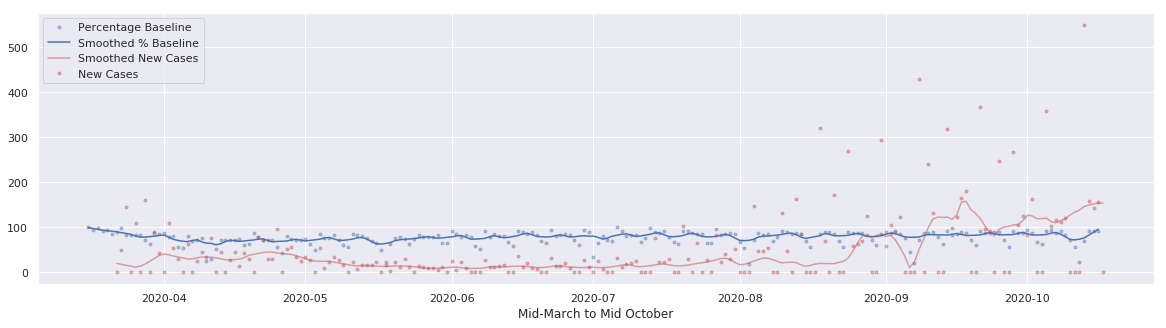

In [4]:
# We see that new cases per day is 0 sometimes, which isn't actually true, just that maybe
# the cases found for a couple of days aren't logged that day, but instead logged on another day, so we should
# smooth the new cases over a couple of days
# We also want to smooth out the weekly cycles in the data to see the long-run correlations
from statsmodels.nonparametric.smoothers_lowess import lowess
new_cases_smooth = lowess(yvrCases['Difference'], yvrCases["timestamp"], frac =0.05)#,is_sorted = True, return_sorted=False)
baseline_smooth = lowess(yvr['PercentOfBaseline'], yvr["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
yvrCases['Diff_smooth'] = new_cases_smooth[:,1]
yvr['Baseline_smooth'] = baseline_smooth[:,1]
# This is to make sure both yvr and yvrCases start and end on the same dates
if (yvr.count().loc['Date'] != yvrCases.count().loc['Date']):
    joined = yvrCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yvr[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yvrCases["Diff_smooth"]
    y = yvr["Baseline_smooth"]

print(joined.count())
#can use X,y or original, doesn't really matter
plt.figure(figsize = (20,5))
plt.plot(yvr["Date"], yvr['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yvr["Date"], yvr['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yvrCases["Date"], yvrCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yvrCases["Date"], yvrCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

0.3320289080751596


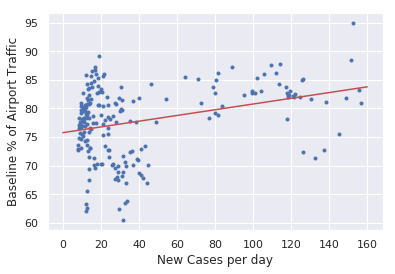

In [5]:
# Is there statistical correlation between the two values- Baseline, and New Cases?
# We use smoothed versions of data because don't want to analyze the weekly noise (tho holidays still exist)
# y = Diff
from scipy import stats
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)
print(regression.rvalue)
linearX = np.linspace(0,160)
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')
#Data, especially X is unbalanced really. The r-value is too low to indicate some sort of relation between
# the two pieces of data

0.48263389848560434


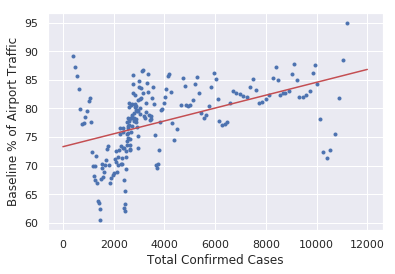

In [6]:
# What about confirmed?
#smooth it, and then plot it
joined
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04) #to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')
reg = stats.linregress(confirmX, y)
print(reg.rvalue)
linearX = np.linspace(0,12000)
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')
# slightly better but still terrible. Though interesting to see that consistent dip in airport traffic when the 
# total was around 2000 this was probably due to the inital shock in the early parts of the pandemic

In [7]:
# Analyzing statistical correlation in --> first wave

In [8]:
# ML with new cases, total cases, global cases: total + new, vs y= Baseline

In [9]:
temp = yvr.shift(-1)
temp["PercentOfBaseline"] = temp["PercentOfBaseline"]

X = np.array(yvr['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)

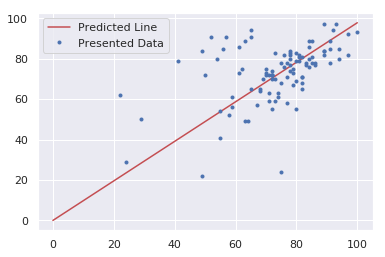

In [12]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
linearX = np.linspace(0,100).reshape(-1,1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

# YEG

In [13]:
yeg = pd.read_csv('yeg4analyze_both.csv',index_col =0, parse_dates = [1])
yegCases = pd.read_csv('Covid-Data/yeg-modified.csv', index_col =0, parse_dates = [5])

yeg["Date"] = pd.to_datetime(yeg["Date"])
yegCases["Date"] = pd.to_datetime(yegCases["Date"])

yegCases.loc[0, "Difference"] = 0

In [20]:
yegCases

,Case-Fatality_Ratio,Combined_Key,Confirmed,Country/Region,Date,Deaths,Incidence_Rate,Latitude,Longitude,Province/State,Recovered,Difference,timestamp,Prediction,Month,Diff_smooth
Active,,,,,,,,,,,,,,,,
0.0,NaN,"Alberta, Canada",259,Canada,2020-03-22,1,NaN,53.9333,-116.5765,Alberta,0,0,1.584835e+09,39.552632,March,0.0
0.0,NaN,"Alberta, Canada",301,Canada,2020-03-23,1,NaN,53.9333,-116.5765,Alberta,0,0,1.584922e+09,41.964912,March,0.0
0.0,NaN,"Alberta, Canada",359,Canada,2020-03-24,1,NaN,53.9333,-116.5765,Alberta,0,0,1.585008e+09,44.377193,March,0.0
0.0,NaN,"Alberta, Canada",358,Canada,2020-03-25,2,NaN,53.9333,-116.5765,Alberta,0,0,1.585094e+09,46.789474,March,0.0
0.0,NaN,"Alberta, Canada",486,Canada,2020-03-26,2,NaN,53.9333,-116.5765,Alberta,0,0,1.585181e+09,49.201754,March,0.0
0.0,NaN,"Alberta, Canada",542,Canada,2020-03-27,2,NaN,53.9333,-116.5765,Alberta,0,0,1.585267e+09,51.614035,March,0.0
0.0,NaN,"Alberta, Canada",542,Canada,2020-03-28,2,NaN,53.9333,-116.5765,Alberta,0,0,1.585354e+09,54.026316,March,0.0
0.0,NaN,"Alberta, Canada",621,Canada,2020-03-29,2,NaN,53.9333,-116.5765,Alberta,0,0,1.585440e+09,56.438596,March,0.0
0.0,NaN,"Alberta, Canada",661,Canada,2020-03-30,3,NaN,53.9333,-116.5765,Alberta,0,0,1.585526e+09,58.850877,March,0.0


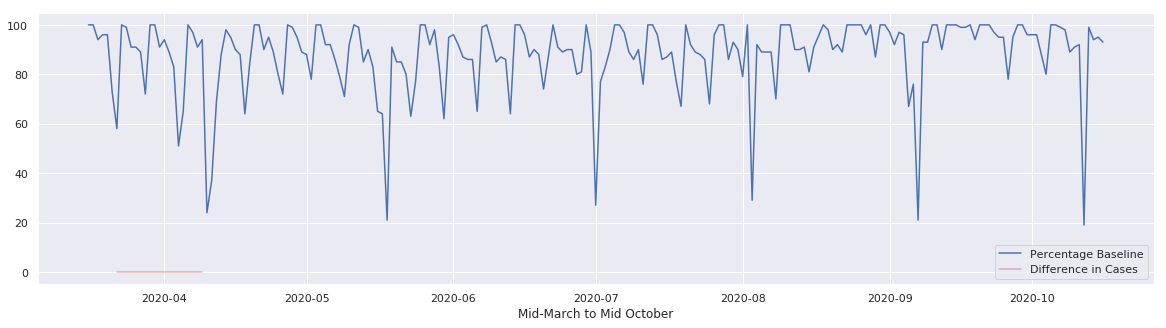

In [14]:
plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b-', label = 'Percentage Baseline')
plt.plot(yegCases["Date"], yegCases['Difference'], 'r-', label = 'Difference in Cases', alpha = 0.4)
#plt.plot(yegCases["Date"], yegCases['Confirmed'], 'm-', label = 'Difference in Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

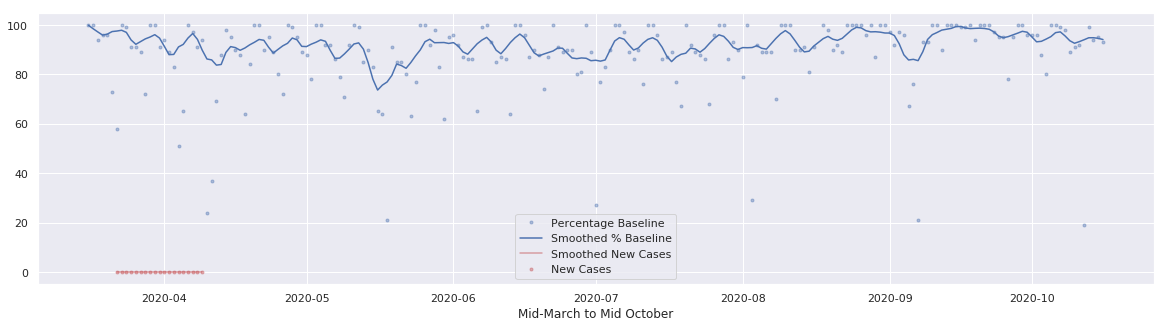

In [15]:
# Small curve in initial phase (Mid-Apr), flattened down shortly after 
# Steep increases after the Summer - look for causes 
# Called in military to assist with rising cases; lockdown
# % Baseline didn't change dramatically (decrease in business trips and international travel)
# Small dips

new_cases_smooth = lowess(yegCases['Difference'], yegCases["timestamp"], frac =0.05)
#to reduce weekly cycle effect 7/214 = 0.327
baseline_smooth = lowess(yeg['PercentOfBaseline'], yeg["Date"], frac =0.04) 
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yegCases['Diff_smooth'] = new_cases_smooth[:,1]
yeg['Baseline_smooth'] = baseline_smooth[:,1]

# Ensure both yeg and yegCases start and end on the same dates
if (yeg.count().loc['Date'] != yegCases.count().loc['Date']):
    joined = yegCases[["Date","Difference","Confirmed","Diff_smooth"]].join(yeg[["Date","PercentOfBaseline","Baseline_smooth"]].set_index('Date'), on='Date')
    joined = joined.dropna()
    X = joined["Diff_smooth"]
    y = joined["Baseline_smooth"]
else:
    X = yegCases["Diff_smooth"]
    y = yeg["Baseline_smooth"]

plt.figure(figsize = (20,5))
plt.plot(yeg["Date"], yeg['PercentOfBaseline'], 'b.', label = 'Percentage Baseline', alpha=0.4)
plt.plot(yeg["Date"], yeg['Baseline_smooth'],'b-',label = 'Smoothed % Baseline')
plt.plot(yegCases["Date"], yegCases["Diff_smooth"], 'r-', label = 'Smoothed New Cases', alpha = 0.5)
plt.plot(yegCases["Date"], yegCases['Difference'], 'r.', label = 'New Cases', alpha = 0.4)
plt.xlabel("Mid-March to Mid October")
plt.legend()
plt.show()

0.0


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:128: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


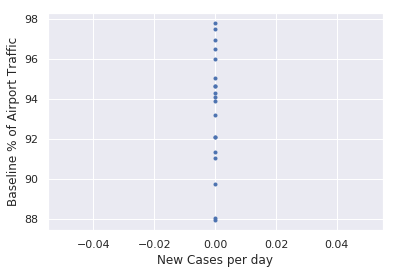

In [16]:
 # Find statistical correlation between the two values- Baseline, and New Cases, using the filtered data from above
plt.plot(X,y, 'b.')
plt.xlabel('New Cases per day')
plt.ylabel('Baseline % of Airport Traffic')
regression = stats.linregress(X, y)

print(regression.rvalue)

linearX = np.linspace(0,160) # why 160
plt.plot(linearX, regression.slope*linearX + regression.intercept,'r-')

# ???
# r-value: Slight but negligible correlation 
# imbalanced data??

-0.44020162651200145


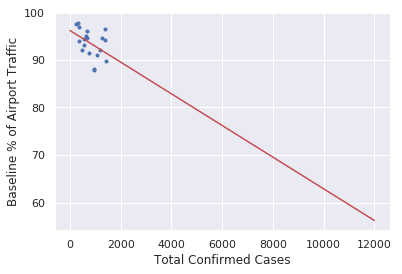

In [17]:
# Repeat for Number of Confirmed Patients
confirm_smooth = lowess(joined['Confirmed'], joined["Date"], frac =0.04)
# to reduce weekly cycle effect 7/214 = 0.327
confirmX = confirm_smooth[:,1]
plt.plot(confirmX,y, 'b.')
plt.xlabel('Total Confirmed Cases')
plt.ylabel('Baseline % of Airport Traffic')

reg = stats.linregress(confirmX, y)

print(reg.rvalue)

linearX = np.linspace(0,12000) # 12000
plt.plot(linearX, reg.slope*linearX + reg.intercept,'r-')

# r-value: slight positive correlation 

In [18]:
temp = yeg.shift(-1)

X = np.array(yeg['PercentOfBaseline'].head(100)).reshape(-1, 1)
y = np.array(temp["PercentOfBaseline"].head(100)).astype(int).reshape(-1, 1)

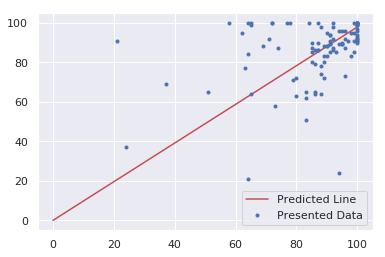

In [19]:
model = LinearRegression(fit_intercept = False)
model.fit(X, y)
linearX = np.linspace(0,100).reshape(-1, 1) #maybe change params
plt.plot(linearX, model.predict(linearX), 'r-', label = "Predicted Line")
plt.plot(X, y, 'b.', label = 'Presented Data')
plt.legend()

# ???